In [1]:
from scipy import signal
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# referred to this article for general idea of canny detection:
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

#references for images have been written in the report

In [3]:
#Hysterisis Thresholding

def hist_thresh(pixel, th = 50, tl = 20):
    if pixel >= th:
        pixel = 255
    elif pixel >= tl:
        pixel = 20
    else:
        pixel = 0
    return pixel

v_hist_thresh = np.vectorize(hist_thresh)


#binary thresholding
def binary_thresh(pixel, t = 127):
    if pixel >= t:
        pixel = 255
    else:
        pixel = 0
    return pixel

v_binary_thresh = np.vectorize(binary_thresh)

In [4]:
sobelx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0 ,1]], np.float32)
sobely = np.array([[-1,-2,-1],
                   [0, 0 ,0],
                   [1, 2, 1]], np.float32)
gaussian = np.array([[1, 2, 1],
                    [2, 4 ,2],
                    [1, 2, 1]], np.float32) / 16

#Hysterisis Thresholding
def hist_thresh(pixel, th = 50, tl = 20):
    if pixel >= th:
        pixel = 255
    elif pixel >= tl:
        pixel = 20
    else:
        pixel = 0
    return pixel
v_hist_thresh = np.vectorize(hist_thresh)

#binary thresholding
def binary_thresh(pixel, t = 127):
    if pixel >= t:
        pixel = 255
    else:
        pixel = 0
    return pixel

v_binary_thresh = np.vectorize(binary_thresh)

#Function for Canny Edge Detection
def canny_edge_detector(arr, th = 100, tl = 50, t_grad = 80, color = True):
    
    if color:
        org_red = arr[:,:,0]
        org_green = arr[:,:,1]
        org_blue = arr[:,:,2]

        G_arr = np.zeros(org_red.shape)
        theta_arr = np.zeros(org_red.shape) 
        dRdx = np.zeros(org_red.shape)
        dRdy = np.zeros(org_red.shape)
        dGdx = np.zeros(org_red.shape)
        dGdy = np.zeros(org_red.shape)
        dBdx = np.zeros(org_red.shape)
        dBdy = np.zeros(org_red.shape)
        red = org_red.copy()
        green = org_green.copy()
        blue = org_blue.copy()
        
        #smoothing with Gaussian kernel
        red = signal.convolve2d(org_red, gaussian)
        green = signal.convolve2d(org_green, gaussian)
        blue = signal.convolve2d(org_blue, gaussian)

        #calculating gradient using convolution with Sobel operators      
        dRdx = signal.convolve2d(red ,sobelx)
        dRdy = signal.convolve2d(red , sobely)
        dGdx = signal.convolve2d(green, sobelx)
        dGdy = signal.convolve2d(green, sobely)
        dBdx = signal.convolve2d(blue, sobelx)
        dBdy = signal.convolve2d(blue, sobely)
        gxx = abs(dRdx)**2 + abs(dGdx)**2 + abs(dBdx)**2
        gyy = abs(dRdy)**2 + abs(dGdy)**2 + abs(dBdy)**2
        gxy = dRdx*dRdy + dGdx*dGdy + dBdx*dBdy 
        theta_arr = 0.5*np.arctan2(2*gxy, gxx - gyy)
        G_arr = np.sqrt(0.5*(gxx + gyy + (gxx-gyy)*np.cos(2*theta_arr) + 2*gxy*np.sin(2*theta_arr)))
    
    else: #if grayscale image or user wants use of intensity channel
        if len(arr.shape) == 3:  
            org_red = arr[:,:,0]
            org_green = arr[:,:,1]
            org_blue = arr[:,:,2]
            org_arr = sum([org_red,org_green,org_blue])/3  #intensity
        
        dFdx = np.zeros(org_arr.shape)
        dFdy = np.zeros(org_arr.shape)
        new_arr = org_arr.copy()
        #smoothing with Gaussian kernel
        new_arr = signal.convolve2d(org_arr, gaussian)
        
        #calculating gradient using convolution with Sobel operators      
        dFdx = signal.convolve2d(new_arr, sobelx)
        dFdy = signal.convolve2d(new_arr, sobely)
        G_arr = np.sqrt(dFdx **2 + dFdy ** 2)
        theta_arr = np.arctan2(dFdy, dFdx)
        
    G_arr = G_arr * 255 / G_arr.max()  #scale grad values to range [0,255]
    Gn = np.zeros(G_arr.shape, dtype=np.int32)
    angle = theta_arr * 180. / np.pi  #convert to degrees
    
    for i in range(1,arr.shape[0]-1):
        for j in range(1,arr.shape[1]-1):

            q = 255 #will hold grad value of first neighbour
            r = 255 #will hold grad value of second neighbour
            theta = angle[i,j]

            #Four types of edge directions: Horizontal, Vertical, +45 deg, -45 deg
            #Digital Image Processing by Gonzalez and Woods, page 731
            if (-180 <= theta < -157.5) or (-22.5 <= theta < 22.5) or (157.5 <= theta <= 180):
                q = G_arr[i, j+1]
                r = G_arr[i, j-1]
            elif (22.5 <= theta < 67.5) or (-157.5 <= theta <= -112.5):
                q = G_arr[i+1, j-1]
                r = G_arr[i-1, j+1]
            elif (67.5 <= theta < 112.5) or (-112.5 <= theta < -67.5):
                q = G_arr[i+1, j]
                r = G_arr[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= theta < -22.5):
                q = G_arr[i-1, j-1]
                r = G_arr[i+1, j+1]

            #if value of grad is more than value of grad at both neighbours 
            # ... along direction, then set Z = grad at [i,j]
            #otherwise set Z = 0 at [i,j]
            if (G_arr[i,j] >= q) and (G_arr[i,j] >= r):
                Gn[i,j] = G_arr[i,j]
            else:
                Gn[i,j] = 0
                
    strong_weak = v_hist_thresh(Gn, th, tl)
    final_canny = strong_weak.copy()
    for i in range(1, strong_weak.shape[0]-1):
        for j in range(1, strong_weak.shape[1]-1):
            if (strong_weak[i,j] != 0) and (strong_weak[i,j] != 255): #if weak pixel
                final_canny[i,j] = float(255 in strong_weak[i-1:i+2, j-1:j+2]) * 255
    binary_grad = v_binary_thresh(G_arr, t_grad)
    
    return final_canny, binary_grad

Text(0.5, 1.0, 'Thresholding Gradient')

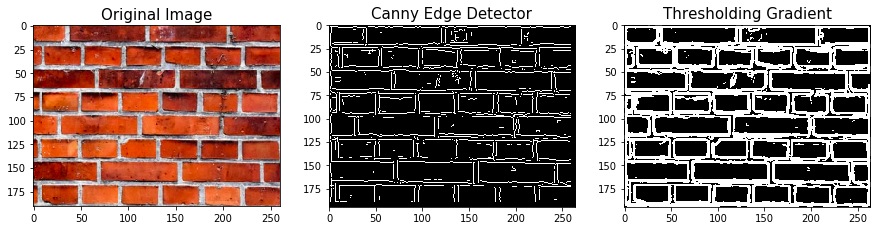

In [5]:
img = Image.open('brick_wall.png')
img = np.array(img)[...,:3]  #transparency channel (4th) removed
canny, grad = canny_edge_detector(img, 50, 25, 50)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(canny, cmap = 'gray')
ax2.set_title('Canny Edge Detector', fontsize = 15)
ax3.imshow(grad, cmap  = 'gray')
ax3.set_title('Thresholding Gradient', fontsize = 15)

Text(0.5, 1.0, 'Thresholding Gradient')

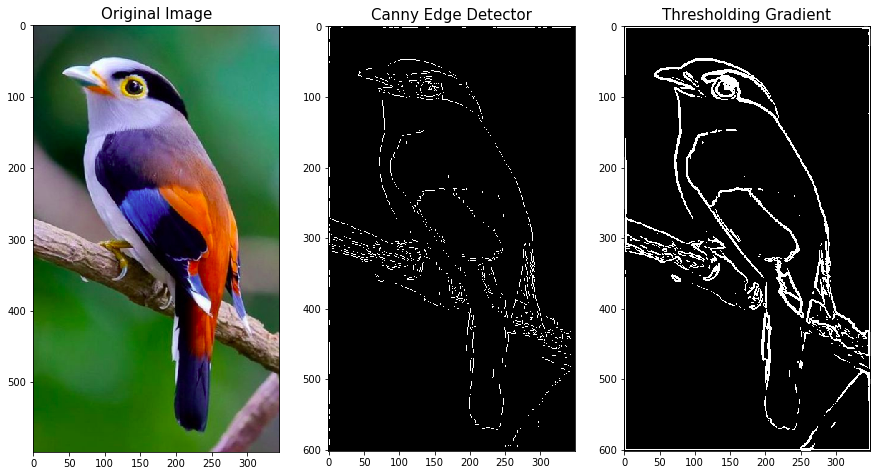

In [6]:
img = Image.open('bird.png')
img = np.array(img)[...,:3]  #transparency channel (4th) removed
canny, grad = canny_edge_detector(img, 50, 25, 50)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(canny, cmap = 'gray')
ax2.set_title('Canny Edge Detector', fontsize = 15)
ax3.imshow(grad, cmap  = 'gray')
ax3.set_title('Thresholding Gradient', fontsize = 15)

Text(0.5, 1.0, 'Thresholding Gradient')

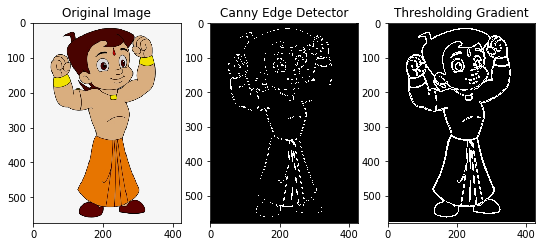

In [7]:
img = Image.open('bheem1.png')
img = np.array(img)[:,:,:3]  #transparency channel (4th) removed
canny, grad = canny_edge_detector(img, 50, 25, 50)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 12)
ax2.imshow(canny, cmap = 'gray')
ax2.set_title('Canny Edge Detector', fontsize = 12)
ax3.imshow(grad, cmap  = 'gray')
ax3.set_title('Thresholding Gradient', fontsize = 12)

## Morphological Operations

In [8]:
def dilate(org_image, struct_dim = (5,5)):
    image = org_image.copy()
    if org_image.max() == 255:
        image = image/255
    dilated = image.copy()
    h = (struct_dim[0]-1)//2
    b = (struct_dim[1]-1)//2
    for x in range(1, image.shape[0]-1):
        for y in range(1, image.shape[1]-1):
            if 1 in image[x-h:x+h+1, y-b:y-b+1]:
                dilated[x,y] = 1.0
            else:
                dilated[x,y] = 0.0
    return dilated

def erode(org_image, struct_dim = (5,5)):
    image = org_image.copy()
    if org_image.max() == 255:
        image = org_image/255
    eroded = image.copy()
    h = (struct_dim[0]-1)//2
    b = (struct_dim[1]-1)//2
    for x in range(1, image.shape[0]-1):
        for y in range(1, image.shape[1]-1):
            if 0 in image[x-h:x+h+1, y-b:y-b+1]:
                eroded[x,y] = 0.0
            else:
                eroded[x,y] = 1.0
    return eroded

def opening(org_image, struct_dim = (5,5)):
    eroded = erode(org_image, struct_dim)
    opened = dilate(eroded, struct_dim)
    return opened

def closing(org_image, struct_dim = (5,5)):
    dilated = dilate(org_image, struct_dim)
    closed = erode(eroded, struct_dim)
    return closed

Text(0.5, 1.0, 'Thresholding Gradient')

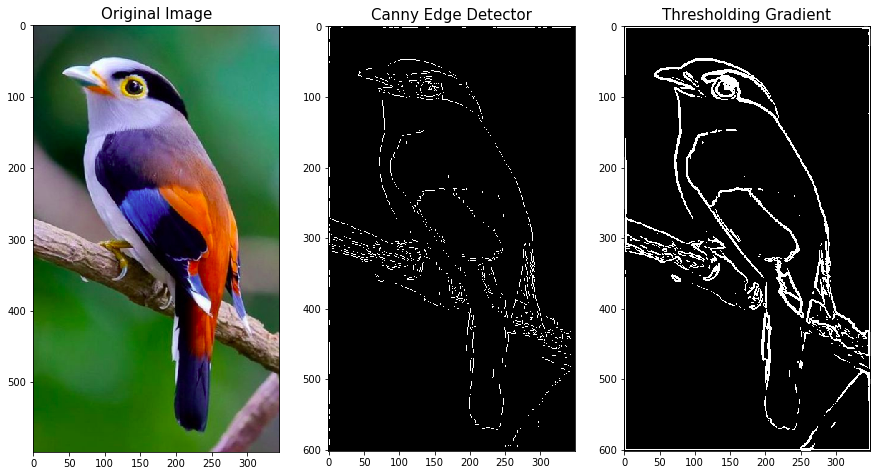

In [9]:
img = Image.open('bird.png')
img = np.array(img)[...,:3]  #transparency channel (4th) removed
canny, grad = canny_edge_detector(img, 50, 25, 50)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(canny, cmap = 'gray')
ax2.set_title('Canny Edge Detector', fontsize = 15)
ax3.imshow(grad, cmap  = 'gray')
ax3.set_title('Thresholding Gradient', fontsize = 15)

Text(0.5, 1.0, 'Thresholding Gradient Output Dilated')

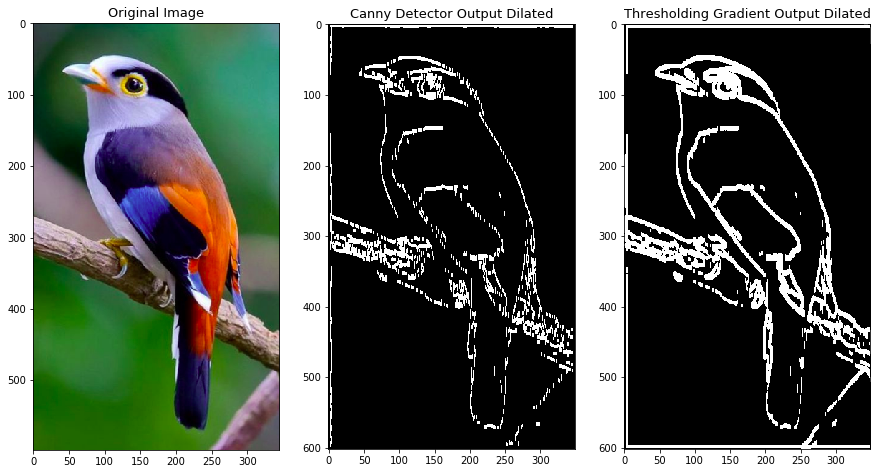

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 13)
ax2.imshow(dilate(canny), cmap = 'gray')
ax2.set_title('Canny Detector Output Dilated', fontsize = 13)
ax3.imshow(dilate(grad), cmap  = 'gray')
ax3.set_title('Thresholding Gradient Output Dilated', fontsize = 13)

Text(0.5, 1.0, 'Dilated')

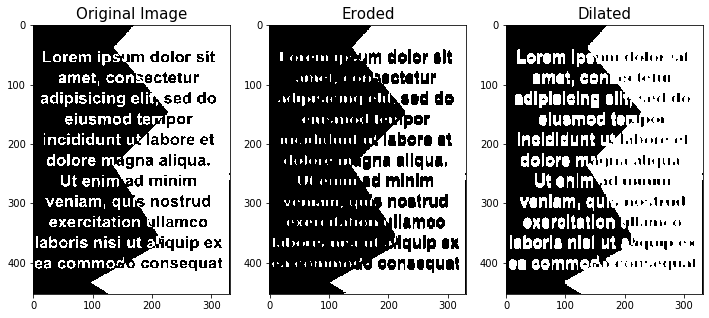

In [11]:
img = np.array(Image.open('lorem_ipsum.png'))
img = np.array(img)[...,0]  #transparency channel (4th) removed
img = (img > 127).astype(int) * 255

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,8))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(erode(img ), cmap = 'gray')
ax2.set_title('Eroded', fontsize = 15)
ax3.imshow(dilate(img), cmap  = 'gray')
ax3.set_title('Dilated', fontsize = 15)

Text(0.5, 1.0, 'Dilated')

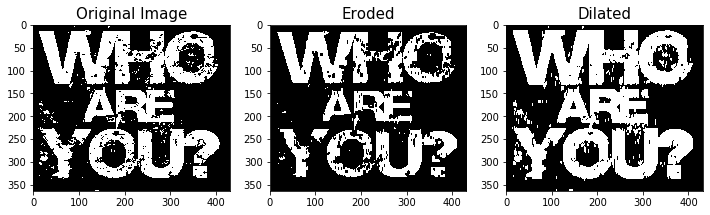

In [12]:
img = np.array(Image.open('who_are_you.png'))
img = np.array(img)[...,0]  #transparency channel (4th) removed
img = (img > 127).astype(int) * 255

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,8))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(erode(img ), cmap = 'gray')
ax2.set_title('Eroded', fontsize = 15)
ax3.imshow(dilate(img), cmap  = 'gray')
ax3.set_title('Dilated', fontsize = 15)